# Importação e preparação dos dados

In [2]:
import pandas as pd

df = pd.read_csv('../dados/excertos_filtrados1000.csv', sep = '|')
df.head()

,COD,DESCR_AREA,filtrado
0,1400,Responsabilidade,voto : cuidar o auto de tomada de conta especi...
1,1700,Finanças Públicas,voto : cuidar o auto de solicitação de o congr...
2,5700,Responsabilidade,relatório : tratar se de embargo de declaração...
3,284,Direito Processual,voto : em relação a outro processo judiciais q...
4,298,Pessoal,": a o ato o senhor , rememorar , desde logo , ..."


In [3]:
df.shape

(13285, 3)

In [4]:
df.groupby(['DESCR_AREA']).size()

DESCR_AREA
Competência do TCU          553
Contrato Administrativo     941
Convênio                    683
Desestatização              139
Direito Processual         1811
Finanças Públicas           328
Gestão Administrativa       338
Licitação                  2756
Pessoal                    3393
Responsabilidade           2343
dtype: int64

In [5]:
areas = df.groupby(['DESCR_AREA']).groups.keys()
areas

dict_keys(['Competência do TCU', 'Contrato Administrativo', 'Convênio', 'Desestatização', 'Direito Processual', 'Finanças Públicas', 'Gestão Administrativa', 'Licitação', 'Pessoal', 'Responsabilidade'])

In [6]:
from sklearn.preprocessing import LabelBinarizer

lbArea = LabelBinarizer()
lbArea.fit([x for x in areas])
lbArea.classes_

array(['Competência do TCU', 'Contrato Administrativo', 'Convênio',
       'Desestatização', 'Direito Processual', 'Finanças Públicas',
       'Gestão Administrativa', 'Licitação', 'Pessoal',
       'Responsabilidade'], dtype='<U23')

In [7]:
y = lbArea.transform(df['DESCR_AREA'])
y.shape

(13285, 10)

In [12]:
from keras.preprocessing.text import Tokenizer
import numpy as np

vocabulario = 26825
limite_texto = 1000
dim_vetor = 50

tokenizer = Tokenizer(num_words=vocabulario)
tokenizer.fit_on_texts(df['filtrado'].astype(str))

sequences = tokenizer.texts_to_sequences(df['filtrado'].astype(str))

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 21578 unique tokens.


In [16]:
max = 0
lens = []
for seq in sequences:
    lens.append(len(seq))
np.min(lens), np.mean(lens), np.max(lens), np.std(lens), len(lens), sum(pd.Series(lens) > 1000), sum(pd.Series(lens) > 1000)/len(lens)

(1,
 494.97041776439596,
 1426,
 241.48463046337437,
 13285,
 5,
 0.0003763643206624012)

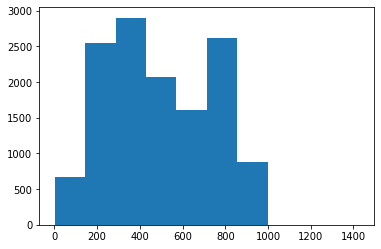

In [18]:
import matplotlib.pyplot as plt
plt.hist(lens)
plt.show()

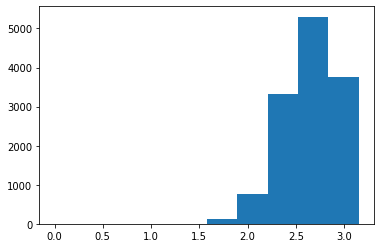

In [19]:
import matplotlib.pyplot as plt
plt.hist(np.log10(lens))
plt.show()

In [20]:
np.percentile(lens, 25), np.percentile(lens, 50), np.percentile(lens, 75), np.percentile(lens, 90), np.percentile(lens, 95)

(290.0, 461.0, 730.0, 841.0, 863.0)

In [21]:
np.mean(np.log10(lens)), 10**np.mean(np.log10(lens)), np.std(np.log10(lens)), (np.mean(np.log10(lens)) + 2*np.std(np.log10(lens))), 10**(np.mean(np.log10(lens)) + 2*np.std(np.log10(lens)))

(2.6292556213109757,
 425.84898976335865,
 0.25910621303326903,
 3.147468047377514,
 1404.3263583859823)

In [22]:
from keras.preprocessing.sequence import pad_sequences

x = pad_sequences(sequences, maxlen=limite_texto)

print('Shape of data tensor:', x.shape)

Shape of data tensor: (13285, 1000)


In [23]:
x.shape, y.shape

((13285, 1000), (13285, 10))

In [26]:
vocabulario = 21578

# Treinamento

In [27]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding
from keras.layers.core import Dropout

#from keras.optimizers import RMSprop
#from keras.layers.core import Dense, Dropout, Activation

model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adadelta',  metrics=["categorical_accuracy"])
model.summary()

W1030 00:07:36.654670 140181425510208 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W1030 00:07:36.682239 140181425510208 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 50)          1078900   
_________________________________________________________________
flatten_2 (Flatten)          (None, 50000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               25600512  
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                2570      
Total para

In [28]:
history = model.fit(x, y, epochs=50, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

Train on 10628 samples, validate on 2657 samples
Epoch 1/50
10628/10628 [==============================] - 12s 1ms/step - loss: 1.6145 - categorical_accuracy: 0.4346 - val_loss: 1.7037 - val_categorical_accuracy: 0.5243
Epoch 2/50
10628/10628 [==============================] - 11s 1ms/step - loss: 0.8850 - categorical_accuracy: 0.7008 - val_loss: 1.2386 - val_categorical_accuracy: 0.6150
Epoch 3/50
10628/10628 [==============================] - 11s 1ms/step - loss: 0.4384 - categorical_accuracy: 0.8627 - val_loss: 1.4726 - val_categorical_accuracy: 0.5559
Epoch 4/50
10628/10628 [==============================] - 11s 1ms/step - loss: 0.2179 - categorical_accuracy: 0.9393 - val_loss: 1.4691 - val_categorical_accuracy: 0.6364
Epoch 5/50
10628/10628 [==============================] - 11s 1ms/step - loss: 0.1169 - categorical_accuracy: 0.9721 - val_loss: 1.5888 - val_categorical_accuracy: 0.6266
Epoch 6/50
10628/10628 [==============================] - 11s 1ms/step - loss: 0.0933 - categori

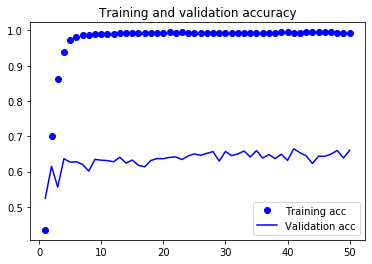

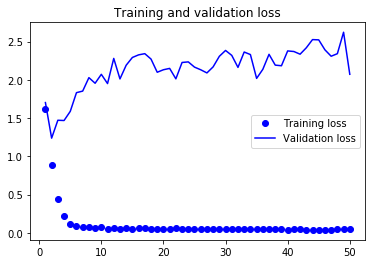

In [29]:
import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [30]:
model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adadelta',  metrics=["categorical_accuracy"])
model.summary()

W1030 00:18:37.096760 140181425510208 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 50)          1078900   
_________________________________________________________________
flatten_3 (Flatten)          (None, 50000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 2048)              102402048 
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                10250     
Total para

In [31]:
history = model.fit(x, y, epochs=50, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

Train on 10628 samples, validate on 2657 samples
Epoch 1/50
10628/10628 [==============================] - 43s 4ms/step - loss: 1.4985 - categorical_accuracy: 0.4737 - val_loss: 1.7717 - val_categorical_accuracy: 0.4851
Epoch 2/50
10628/10628 [==============================] - 40s 4ms/step - loss: 0.7248 - categorical_accuracy: 0.7602 - val_loss: 1.8663 - val_categorical_accuracy: 0.4264
Epoch 3/50
10628/10628 [==============================] - 41s 4ms/step - loss: 0.2153 - categorical_accuracy: 0.9420 - val_loss: 1.4287 - val_categorical_accuracy: 0.6078
Epoch 4/50
10628/10628 [==============================] - 41s 4ms/step - loss: 0.0865 - categorical_accuracy: 0.9858 - val_loss: 1.9362 - val_categorical_accuracy: 0.5965
Epoch 5/50
10628/10628 [==============================] - 41s 4ms/step - loss: 0.0659 - categorical_accuracy: 0.9917 - val_loss: 2.0051 - val_categorical_accuracy: 0.5841
Epoch 6/50
10628/10628 [==============================] - 41s 4ms/step - loss: 0.0635 - categori

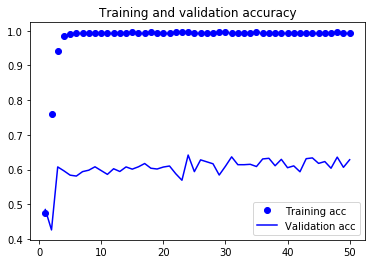

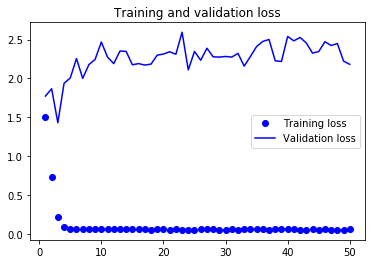

In [32]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [33]:
model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adadelta',  metrics=["categorical_accuracy"])

history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

Train on 10628 samples, validate on 2657 samples
Epoch 1/20
10628/10628 [==============================] - 42s 4ms/step - loss: 1.5776 - categorical_accuracy: 0.4430 - val_loss: 1.3021 - val_categorical_accuracy: 0.5359
Epoch 2/20
10628/10628 [==============================] - 39s 4ms/step - loss: 0.7452 - categorical_accuracy: 0.7535 - val_loss: 1.3190 - val_categorical_accuracy: 0.5928
Epoch 3/20
10628/10628 [==============================] - 39s 4ms/step - loss: 0.1714 - categorical_accuracy: 0.9586 - val_loss: 1.6042 - val_categorical_accuracy: 0.5886
Epoch 4/20
10628/10628 [==============================] - 39s 4ms/step - loss: 0.0659 - categorical_accuracy: 0.9911 - val_loss: 1.9420 - val_categorical_accuracy: 0.5664
Epoch 5/20
10628/10628 [==============================] - 39s 4ms/step - loss: 0.0521 - categorical_accuracy: 0.9939 - val_loss: 1.9632 - val_categorical_accuracy: 0.6003
Epoch 6/20
10628/10628 [==============================] - 39s 4ms/step - loss: 0.0481 - categori

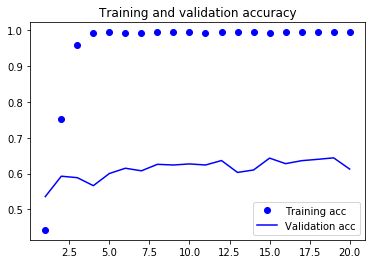

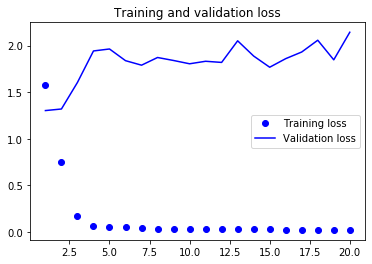

In [34]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [36]:
for linha in df.index:
    f = df.loc[linha, 'filtrado']
    try:
        x = len(f)
    except:
        print (linha)

11410
11999


In [39]:
df.loc[11410]

COD                        37522
DESCR_AREA    Direito Processual
filtrado                     NaN
Name: 11410, dtype: object

In [38]:
df.loc[11999]

COD             43342
DESCR_AREA    Pessoal
filtrado          NaN
Name: 11999, dtype: object